In [33]:
import numpy as np
from scipy import sparse

import h2o
from h2o.automl import H2OAutoML
h2o.init(nthreads = 4,max_mem_size = "12G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /home/alex/miniconda3/envs/h20/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3of5licv
  JVM stdout: /tmp/tmp3of5licv/h2o_alex_started_from_python.out
  JVM stderr: /tmp/tmp3of5licv/h2o_alex_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,16 days
H2O cluster name:,H2O_from_python_alex_mbmoiw
H2O cluster total nodes:,1
H2O cluster free memory:,12 Gb
H2O cluster total cores:,6
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [2]:
%%time
# Experiment 1
X_train = np.load("../processed_data/full_lemma_keyword_pca_50_pipeline_tf_train_ndarray.npy")
X_test = np.load("../processed_data/full_lemma_keyword_pca_50_pipeline_tf_test_ndarray.npy")

X_train = h2o.H2OFrame(X_train)
X_test = h2o.H2OFrame(X_test)

y = X_train.columns[-1]
x = X_train.columns
x.remove(y)

aml = H2OAutoML(max_models = 10, 
                seed = 1,
                verbosity='debug',
               )
aml.train(x = x, y = y, training_frame = X_train)

# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

metalearner.coef_norm()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
23:27:51.862: Project: AutoML_20200221_232751860
23:27:51.862: Setting stopping tolerance adaptively based on the training frame: 0.011460988720255175
23:27:51.862: Build control seed: 1
23:27:51.863: training frame: Frame key: automl_training_Key_Frame__upload_a64c4a5544f95b80afd19d09cb64459b.hex    cols: 242    rows: 7613  chunks: 4    size: 3150109  checksum: -1202237540327242178
23:27:51.863: validation frame: NULL
23:27:51.863: leaderboard frame: NULL
23:27:51.863: blending frame: NULL
23:27:51.863: response column: C242
23:27:51.863: fold column: null
23:27:51.863: weights column: null
23:27:51.869: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {Stac

{'Intercept': 0.34257191645868984,
 'XGBoost_1_AutoML_20200221_232751': 0.05576652257573207,
 'DRF_1_AutoML_20200221_232751': 0.061332121090884886,
 'XGBoost_3_AutoML_20200221_232751': 0.02941413881503072,
 'GBM_4_AutoML_20200221_232751': 0.01428765587910585,
 'XGBoost_2_AutoML_20200221_232751': 0.07165427133901207,
 'GBM_3_AutoML_20200221_232751': 0.0,
 'GBM_1_AutoML_20200221_232751': 0.023564014208765,
 'GBM_2_AutoML_20200221_232751': 0.0,
 'GBM_5_AutoML_20200221_232751': 0.00280615106051427,
 'GLM_1_AutoML_20200221_232751': 0.0012646711768132368}

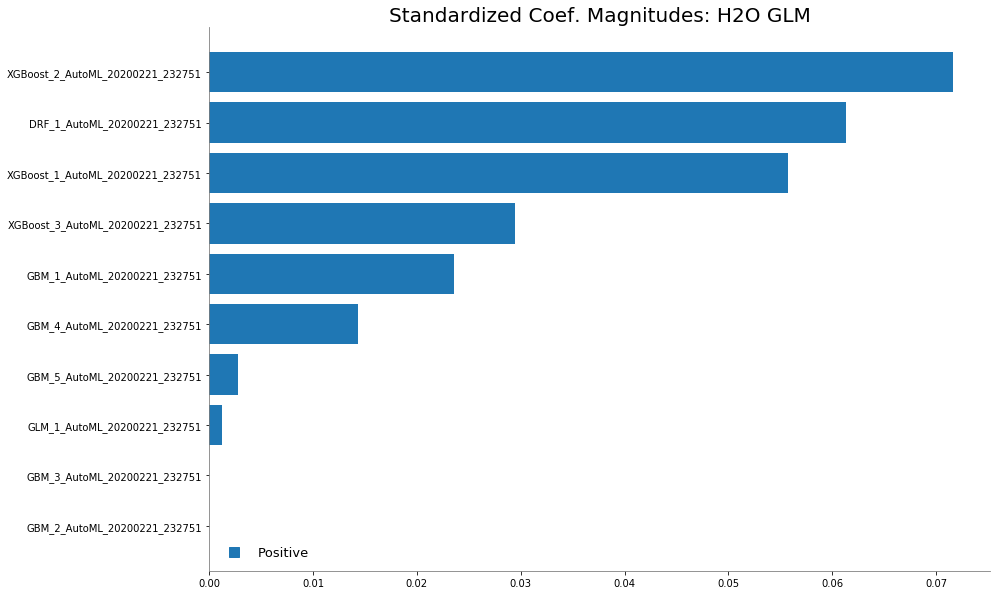

In [3]:
%matplotlib inline
metalearner.std_coef_plot()

In [5]:
# Experiment 1 Prediction Test
predictions1 = aml.predict(X_test)
predictions1.shape

stackedensemble prediction progress: |████████████████████████████████████| 100%


(3263, 1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
23:43:55.160: Project: AutoML_20200221_234355159
23:43:55.160: Setting stopping tolerance adaptively based on the training frame: 0.011460988720255175
23:43:55.160: Build control seed: 1
23:43:55.160: training frame: Frame key: automl_training_py_117_sid_a762    cols: 242    rows: 7613  chunks: 3    size: 3131656  checksum: 2064656790548190256
23:43:55.160: validation frame: NULL
23:43:55.160: leaderboard frame: NULL
23:43:55.160: blending frame: NULL
23:43:55.160: response column: C242
23:43:55.160: fold column: null
23:43:55.160: weights column: null
23:43:55.160: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
23:43:55.160: A

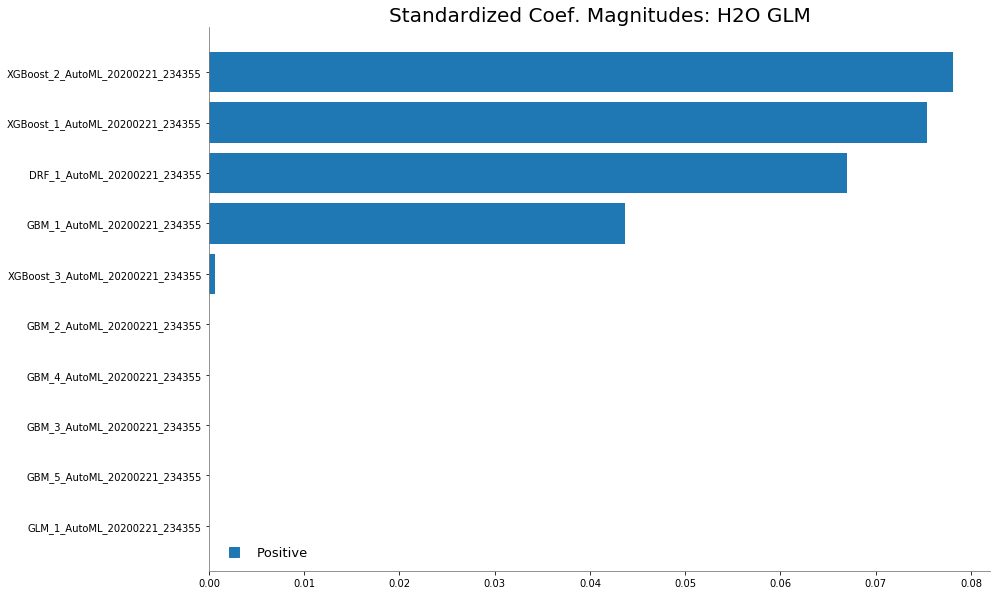

CPU times: user 6.95 s, sys: 156 ms, total: 7.11 s
Wall time: 1min 31s


In [7]:
%%time
# Experiment 2
X_train = sparse.load_npz("../processed_data/full_lemma_keyword_pca_50_pipeline_tt_train_sparse.npz")
X_test = sparse.load_npz("../processed_data/full_lemma_keyword_pca_50_pipeline_tt_test_sparse.npz")

X_train = h2o.H2OFrame(X_train)
X_test = h2o.H2OFrame(X_test)

y = X_train.columns[-1]
x = X_train.columns
x.remove(y)

aml = H2OAutoML(max_models = 10, 
                seed = 1,
                verbosity='debug',
               )
aml.train(x = x, y = y, training_frame = X_train)

# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

print(metalearner.coef_norm())

%matplotlib inline
metalearner.std_coef_plot()

In [9]:
# Experiment 2 Prediction Test
predictions2 = aml.predict(X_test)
predictions2.shape

stackedensemble prediction progress: |████████████████████████████████████| 100%


(3263, 1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
00:07:13.501: Project: AutoML_20200222_00713499
00:07:13.502: Setting stopping tolerance adaptively based on the training frame: 0.011460988720255175
00:07:13.502: Build control seed: 1
00:07:13.502: training frame: Frame key: automl_training_py_1_sid_a749    cols: 275    rows: 7613  chunks: 3    size: 3139444  checksum: 5360252508036772992
00:07:13.502: validation frame: NULL
00:07:13.502: leaderboard frame: NULL
00:07:13.502: blending frame: NULL
00:07:13.502: response column: C275
00:07:13.502: fold column: null
00:07:13.502: weights column: null
00:07:13.510: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
00:07:13.515: Auto

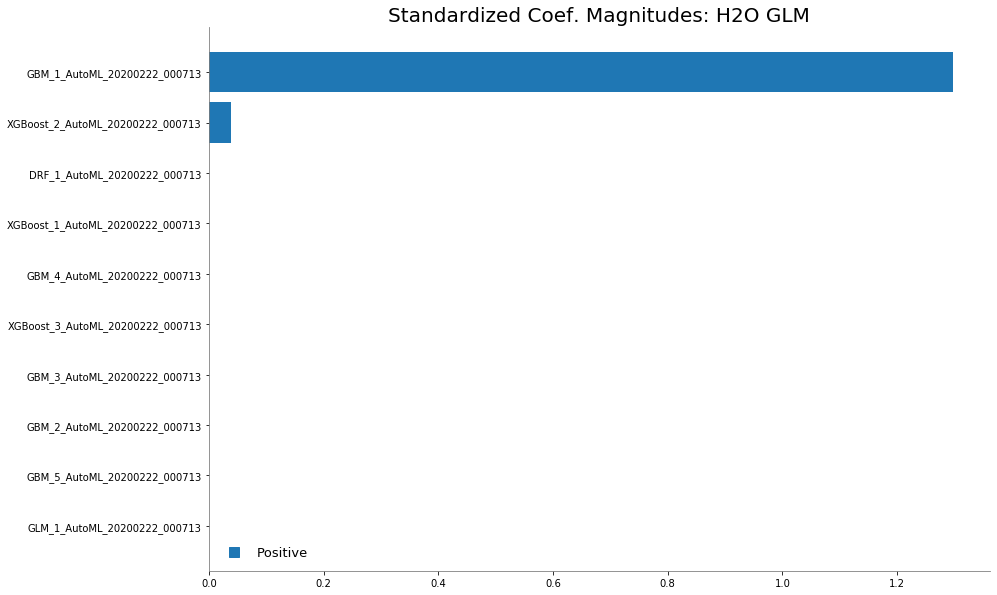

CPU times: user 5.94 s, sys: 166 ms, total: 6.1 s
Wall time: 1min 33s


In [2]:
%%time
# Experiment 3 - bow pca 50
X_train = sparse.load_npz("../processed_data/full_raw_keyword_bow_pca_50_pipeline_tt_train_sparse.npz")
X_test = sparse.load_npz("../processed_data/full_raw_keyword_bow_pca_50_pipeline_tt_test_sparse.npz")

X_train = h2o.H2OFrame(X_train)
X_test = h2o.H2OFrame(X_test)

y = X_train.columns[-1]
x = X_train.columns
x.remove(y)

aml = H2OAutoML(max_models = 10, 
                seed = 1,
                verbosity='info',
               )
aml.train(x = x, y = y, training_frame = X_train)

# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

print(metalearner.coef_norm())

%matplotlib inline
metalearner.std_coef_plot()

In [3]:
# Experiment 3 Prediction Test
predictions3 = aml.predict(X_test)
predictions3.shape

gbm prediction progress: |████████████████████████████████████████████████| 100%


(3263, 1)

In [37]:
# X_train = sparse.load_npz("../processed_data/full_raw_keyword_bow_pipeline_tt_train_sparse.npz")
X_train = np.load("../full_raw_keyword_bow_pipeline_tt_train_ndarray.npy")
# y_train = np.load("processed_data/raw_keyword_categorical_y_train.npy")
# y_train = h2o.H2OFrame(y_train)
# X_test = sparse.load_npz("../processed_data/full_raw_keyword_bow_pipeline_tt_test_sparse.npz")
X_test = np.load("../full_raw_keyword_bow_pipeline_tt_test_ndarray.npy")

X_train = h2o.H2OFrame(X_train)
X_test = h2o.H2OFrame(X_test)

# combined_train = X_train.cbind(y_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [41]:
X_train.shape

(7613, 20338)

In [42]:
X_test.shape

(3263, 20337)

In [43]:
y = X_train.columns[-1]
x = X_train.columns
x.remove(y)

# Ensure binary target is a factor
X_train[y] = X_train[y].asfactor()

In [29]:
# y = "C110000"
# x = combined_train.columns
# x.remove(y)

# Run AutoML

In [45]:
aml = H2OAutoML(max_models = 20, 
                seed = 1,
                verbosity='info',
#                 max_runtime_secs = 30, # For debugging
               )
aml.train(x = x, y = y, training_frame = X_train)

AutoML progress: |
13:21:16.253: Project: AutoML_20200222_132116250
13:21:16.265: Setting stopping tolerance adaptively based on the training frame: 0.011460988720255175
13:21:16.265: Build control seed: 1
13:21:16.289: training frame: Frame key: automl_training_py_851_sid_a6a5    cols: 20338    rows: 7613  chunks: 148    size: 240807846  checksum: -8586601818324432240
13:21:16.289: validation frame: NULL
13:21:16.289: leaderboard frame: NULL
13:21:16.289: blending frame: NULL
13:21:16.289: response column: C20338
13:21:16.289: fold column: null
13:21:16.289: weights column: null
13:21:16.398: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
13:21:16.403: AutoML job created: 2020.02.22 13:21:16.250
13:21:16.404: AutoML build started: 2020.02.22 13:21:16.403
13:21:16.493: AutoML: starting XGBoost_1_AutoML_20

In [46]:
aml.modeling_steps

[{'name': 'XGBoost',
  'steps': [{'id': 'def_1', 'weight': 10},
   {'id': 'def_2', 'weight': 10},
   {'id': 'def_3', 'weight': 10}]},
 {'name': 'GLM', 'steps': [{'id': 'def_1', 'weight': 10}]},
 {'name': 'DRF', 'steps': [{'id': 'def_1', 'weight': 10}]},
 {'name': 'GBM',
  'steps': [{'id': 'def_1', 'weight': 10},
   {'id': 'def_2', 'weight': 10},
   {'id': 'def_3', 'weight': 10},
   {'id': 'def_4', 'weight': 10},
   {'id': 'def_5', 'weight': 10}]},
 {'name': 'DeepLearning', 'steps': [{'id': 'def_1', 'weight': 10}]},
 {'name': 'DRF', 'steps': [{'id': 'XRT', 'weight': 10}]},
 {'name': 'XGBoost', 'steps': [{'id': 'grid_1', 'weight': 100}]},
 {'name': 'GBM', 'steps': [{'id': 'grid_1', 'weight': 60}]},
 {'name': 'DeepLearning',
  'steps': [{'id': 'grid_1', 'weight': 20}, {'id': 'grid_2', 'weight': 20}]},
 {'name': 'StackedEnsemble',
  'steps': [{'id': 'best', 'weight': 10}, {'id': 'all', 'weight': 10}]}]

{'Intercept': -0.22084968506644476, 'XGBoost_grid__1_AutoML_20200222_132116_model_2': 0.27850699616898056, 'GBM_4_AutoML_20200222_132116': 0.36384241842698295, 'GBM_grid__1_AutoML_20200222_132116_model_1': 0.23165007332467588, 'GBM_3_AutoML_20200222_132116': 0.0, 'GBM_2_AutoML_20200222_132116': 0.0, 'GBM_1_AutoML_20200222_132116': 0.0, 'GLM_1_AutoML_20200222_132116': 0.5329696274679702, 'DeepLearning_grid__2_AutoML_20200222_132116_model_1': 0.1785443247147275, 'XGBoost_grid__1_AutoML_20200222_132116_model_1': 0.026158606025897122, 'XGBoost_3_AutoML_20200222_132116': 0.0, 'XGBoost_grid__1_AutoML_20200222_132116_model_4': 0.0, 'DRF_1_AutoML_20200222_132116': 0.14370500884265608, 'XGBoost_1_AutoML_20200222_132116': 0.031497896763378226, 'DeepLearning_1_AutoML_20200222_132116': 0.0878257223706418, 'DeepLearning_grid__1_AutoML_20200222_132116_model_1': 0.14719232235066243, 'XGBoost_grid__1_AutoML_20200222_132116_model_3': 0.0, 'XGBoost_2_AutoML_20200222_132116': 0.0, 'XRT_1_AutoML_20200222_

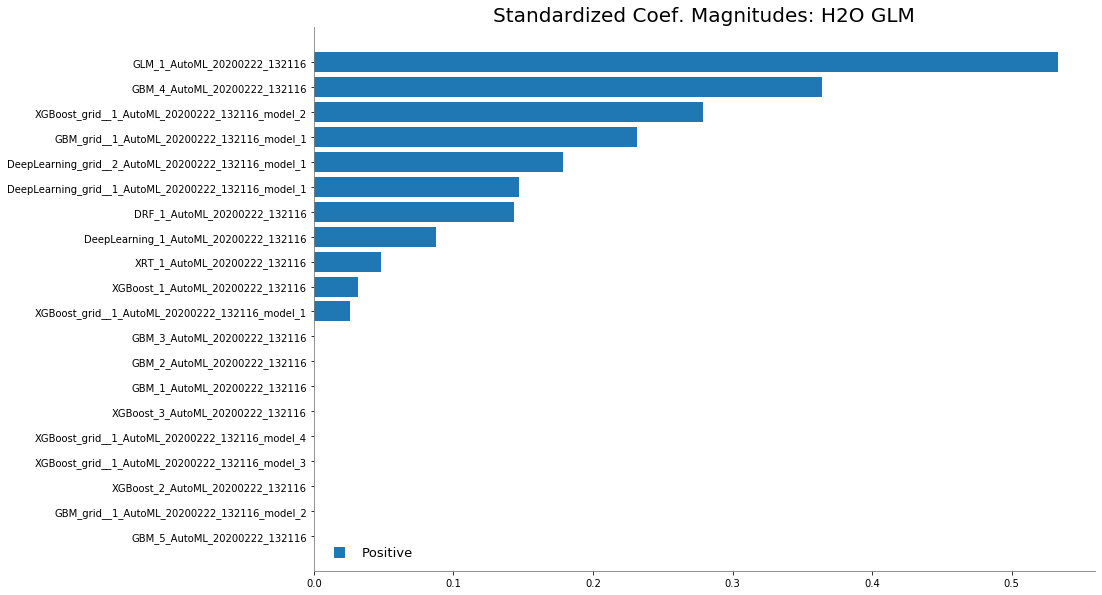

In [47]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

print(metalearner.coef_norm())

%matplotlib inline
metalearner.std_coef_plot()

In [48]:
# Save the model
h2o.save_model(aml.leader, path = "./saved_models/automl_005_bin")

'/home/alex/Documents/mlbase/disaster_tweet_kaggle/h2o/saved_models/automl_005_bin/StackedEnsemble_BestOfFamily_AutoML_20200222_132116'

In [49]:
%%time
# Experiment 5 Prediction Test
predictions5 = aml.predict(X_test)
predictions5.shape

stackedensemble prediction progress: |████████████████████████████████████| 100%
CPU times: user 183 ms, sys: 31.1 ms, total: 214 ms
Wall time: 14.4 s


(3263, 3)

In [53]:
predictions5

predict,p0,p1
1,0.299266,0.700734
1,0.130853,0.869147
1,0.0740614,0.925939
1,0.403016,0.596984
1,0.048906,0.951094
1,0.229236,0.770764
0,0.742732,0.257268
0,0.806888,0.193112
0,0.819966,0.180034
0,0.797184,0.202816


In [50]:
import pandas as pd
test_df = pd.read_csv("../data/test.csv")
test_id = test_df['id']
test_predictions_df = pd.DataFrame([test_id, pd.Series(predictions5.as_data_frame().iloc[:, 0])]).T
test_predictions_df.columns = ['id', 'target']

In [51]:
test_predictions_df.to_csv('test_preds_automl_005.csv', index=False)

In [52]:
lb = aml.leaderboard
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20200222_132116,0.858575,0.446024,0.852109,0.212056,0.378381,0.143172
StackedEnsemble_AllModels_AutoML_20200222_132116,0.858222,0.446052,0.851982,0.214646,0.378411,0.143195
XGBoost_grid__1_AutoML_20200222_132116_model_2,0.847469,0.470319,0.835908,0.221965,0.389852,0.151985
GBM_4_AutoML_20200222_132116,0.845332,0.483274,0.835073,0.226435,0.395535,0.156448
GBM_grid__1_AutoML_20200222_132116_model_1,0.841468,0.500601,0.832605,0.228817,0.402775,0.162228
GBM_3_AutoML_20200222_132116,0.840894,0.494642,0.830746,0.23427,0.400824,0.16066
GBM_2_AutoML_20200222_132116,0.84019,0.496928,0.830837,0.2335,0.40186,0.161492
GBM_1_AutoML_20200222_132116,0.836954,0.503705,0.826798,0.229047,0.404357,0.163505
GLM_1_AutoML_20200222_132116,0.835047,0.491352,0.826733,0.232259,0.398004,0.158407
DeepLearning_grid__2_AutoML_20200222_132116_model_1,0.829,0.652747,0.587207,0.236082,0.411517,0.169346


In [21]:
h2o.save_model(aml.leader, path = "./saved_models/automl_004_bin")

'/home/alex/Documents/mlbase/disaster_tweet_kaggle/h2o/saved_models/automl_004_bin/DeepLearning_grid__1_AutoML_20200222_032428_model_1'

In [23]:
aml2 = h2o.load_model("./saved_models/automl_004_bin/DeepLearning_grid__1_AutoML_20200222_032428_model_1")

In [24]:
dir(aml2)

['F0point5',
 'F1',
 'F2',
 '_ModelBase__generate_partial_plots',
 '_ModelBase__generate_user_splits',
 '_ModelBase__grabValues',
 '_ModelBase__plot_1dpdp',
 '_ModelBase__plot_2dpdp',
 '_ModelBase__predFor3D',
 '_ModelBase__setAxs1D',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_additional_used_columns',
 '_bc',
 '_bci',
 '_check_and_save_parm',
 '_check_targets',
 '_compute_algo',
 '_delegate_to_metrics',
 '_end_time',
 '_estimator_type',
 '_fillMultinomialDict',
 '_future',
 '_get_metrics',
 '_have_mojo',
 '_have_pojo',
 '_id',
 '_is_xvalidated',
 '_job',
 '_keyify_if_h2oframe',
 '_metrics_class',
 '_model_json',
 '_parms',
 '_plot',
 '_print_mod

In [25]:
aml2.F1

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid__1_AutoML_20200222_032428_model_1


Status of Neuron Layers: predicting C20337, 2-class classification, bernoulli distribution, CrossEntropy loss, 4,067,802 weights/biases, 48.8 MB, 27,144 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,20336,Input,20,,,,,,,,,
1,,2,200,RectifierDropout,40,0,0,0.977042,0.00153036,0,0.00727941,0.0481917,0.510095,0.0904652
2,,3,2,Softmax,,0,0,0.902415,0.244836,0,0.00986327,0.38336,0.0265026,0.23966




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 1.7266850582090668e-09
RMSE: 4.155340008000629e-05
LogLoss: 9.267748319421941e-07
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 0.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9996075471647122: 


,,0,1,Error,Rate
0,0,7612.0,0.0,0.0,(0.0/7612.0)
1,1,0.0,1.0,0.0,(0.0/1.0)
2,Total,7612.0,1.0,0.0,(0.0/7613.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,9.996075e-01,1.0,0.0
1,max f2,9.996075e-01,1.0,0.0
2,max f0point5,9.996075e-01,1.0,0.0
3,max accuracy,9.996075e-01,1.0,0.0
4,max precision,9.996075e-01,1.0,0.0
5,max recall,9.996075e-01,1.0,0.0
6,max specificity,9.996075e-01,1.0,0.0
7,max absolute_mcc,9.996075e-01,1.0,0.0
8,max min_per_class_accuracy,9.996075e-01,1.0,0.0
9,max mean_per_class_accuracy,9.996075e-01,1.0,0.0



Gains/Lift Table: Avg response rate:  0.01 %, avg score:  0.01 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010114,1.802922e-10,98.87013,98.870130,0.012987,1.306836e-02,0.012987,0.013068,1.0,1.0,9787.012987,9787.012987
1,,2,0.020229,2.293305e-11,0.00000,49.435065,0.000000,6.132870e-11,0.006494,0.006534,0.0,1.0,-100.000000,4843.506494
2,,3,0.030080,5.540042e-12,0.00000,33.244541,0.000000,1.280717e-11,0.004367,0.004394,0.0,1.0,-100.000000,3224.454148
3,,4,0.040063,1.642750e-12,0.00000,24.960656,0.000000,2.900338e-12,0.003279,0.003299,0.0,1.0,-100.000000,2396.065574
4,,5,0.050046,5.903790e-13,0.00000,19.981627,0.000000,1.013965e-12,0.002625,0.002641,0.0,1.0,-100.000000,1898.162730
5,,6,0.100092,1.023800e-14,0.00000,9.990814,0.000000,1.296480e-13,0.001312,0.001321,0.0,1.0,-100.000000,899.081365
6,,7,0.150007,3.534926e-16,0.00000,6.666375,0.000000,2.963425e-15,0.000876,0.000881,0.0,1.0,-100.000000,566.637478
7,,8,0.200053,1.129864e-17,0.00000,4.998687,0.000000,1.001845e-16,0.000657,0.000661,0.0,1.0,-100.000000,399.868680
8,,9,0.300013,3.732061e-21,0.00000,3.333187,0.000000,1.588717e-18,0.000438,0.000441,0.0,1.0,-100.000000,233.318739
9,,10,0.399974,2.624096e-25,0.00000,2.500164,0.000000,4.595708e-22,0.000328,0.000330,0.0,1.0,-100.000000,150.016420




ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.00013135426277789726
RMSE: 0.011460988734742621
LogLoss: 0.0030228245701911715
Mean Per-Class Error: 0.008867577509195979
AUC: 0.9822648449816079
AUCPR: 0.003676470588235294
Gini: 0.9645296899632159

Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0132437368732008e-10: 


,,0,1,Error,Rate
0,0,7477.0,135.0,0.0177,(135.0/7612.0)
1,1,0.0,1.0,0.0,(0.0/1.0)
2,Total,7477.0,136.0,0.0177,(135.0/7613.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,1.013244e-10,0.014599,135.0
1,max f2,1.013244e-10,0.035714,135.0
2,max f0point5,1.013244e-10,0.009174,135.0
3,max accuracy,5.100234e-05,0.999737,0.0
4,max precision,1.013244e-10,0.007353,135.0
5,max recall,1.013244e-10,1.000000,135.0
6,max specificity,5.100234e-05,0.999869,0.0
7,max absolute_mcc,1.013244e-10,0.084986,135.0
8,max min_per_class_accuracy,1.013244e-10,0.982265,135.0
9,max mean_per_class_accuracy,1.013244e-10,0.991132,135.0



Gains/Lift Table: Avg response rate:  0.01 %, avg score:  0.00 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010114,8.512282e-10,0.000000,0.000000,0.000000,9.025751e-07,0.000000,9.025751e-07,0.0,0.0,-100.000000,-100.000000
1,,2,0.020097,6.870312e-11,100.171053,49.758170,0.013158,2.661291e-10,0.006536,4.543693e-07,1.0,1.0,9917.105263,4875.816993
2,,3,0.030080,6.435641e-12,0.000000,33.244541,0.000000,2.513683e-11,0.004367,3.035826e-07,0.0,1.0,-100.000000,3224.454148
3,,4,0.040063,1.272123e-12,0.000000,24.960656,0.000000,2.979778e-12,0.003279,2.279365e-07,0.0,1.0,-100.000000,2396.065574
4,,5,0.050046,2.141560e-13,0.000000,19.981627,0.000000,6.290080e-13,0.002625,1.824690e-07,0.0,1.0,-100.000000,1898.162730
5,,6,0.100092,1.556618e-16,0.000000,9.990814,0.000000,3.269805e-14,0.001312,9.123452e-08,0.0,1.0,-100.000000,899.081365
6,,7,0.150007,1.083049e-20,0.000000,6.666375,0.000000,2.217211e-17,0.000876,6.087627e-08,0.0,1.0,-100.000000,566.637478
7,,8,0.200053,4.798200e-26,0.000000,4.998687,0.000000,9.142823e-22,0.000657,4.564721e-08,0.0,1.0,-100.000000,399.868680
8,,9,0.300013,3.443183e-39,0.000000,3.333187,0.000000,1.627817e-27,0.000438,3.043814e-08,0.0,1.0,-100.000000,233.318739
9,,10,0.399974,4.852426e-52,0.000000,2.500164,0.000000,1.091184e-40,0.000328,2.283110e-08,0.0,1.0,-100.000000,150.016420




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,auc,0.19027595,0.42546996,0.0,0.9513798,0.0,0.0,0.0
1,aucpr,0.006666667,0.0,NaN,0.006666667,NaN,NaN,NaN
2,lift_top_group,0.0,0.0,NaN,0.0,NaN,NaN,NaN
3,logloss,0.0030220307,0.006757462,2.727688E-10,0.015110146,1.723711E-11,2.6087467E-11,7.156198E-9
4,mean_per_class_error,0.024310118,0.0,NaN,0.024310118,NaN,NaN,NaN
5,mse,1.3131976E-4,2.9363993E-4,1.0240409E-16,6.5659883E-4,5.977388E-20,3.4193868E-19,7.729718E-14
6,pr_auc,0.006666667,0.0,NaN,0.006666667,NaN,NaN,NaN
7,r2,-Infinity,NaN,-Infinity,-6.5703265E-4,-Infinity,-Infinity,-Infinity
8,rmse,0.0051248944,0.011459451,1.0119491E-8,0.025624184,2.4448696E-10,5.8475524E-10,2.780237E-7



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-02-22 11:17:38,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-02-22 11:17:44,39 min 9.779 sec,223 obs/sec,0.170235,1,1296.0,0.011461,4.536821e-03,-0.000131,0.413032,0.000066,0.00000,0.999869
2,,2020-02-22 11:19:54,41 min 19.682 sec,220 obs/sec,3.565480,21,27144.0,0.000042,9.267748e-07,0.999987,1.000000,0.000000,98.87013,0.000000



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C2744,1.000000,1.000000,0.000114
1,C19770,0.987238,0.987238,0.000112
2,C13074,0.965126,0.965126,0.000110
3,C3981,0.961258,0.961258,0.000109
4,C19799,0.955598,0.955598,0.000109
5,C18052,0.947276,0.947276,0.000108
6,C13202,0.934454,0.934454,0.000106
7,C12733,0.914398,0.914398,0.000104
8,C164,0.911760,0.911760,0.000104
9,C17455,0.909137,0.909137,0.000103



See the whole table with table.as_data_frame()


<bound method H2OBinomialModel.F1 of >

In [29]:
di

AttributeError: type object 'ModelBase' has no attribute 'training_info'

In [6]:
lb = aml.leaderboard

In [6]:
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20200221_092127,0.148802,0.385749,0.148802,0.310458,0.270718
StackedEnsemble_AllModels_AutoML_20200221_092127,0.148818,0.38577,0.148818,0.310552,0.270701
XGBoost_2_AutoML_20200221_092127,0.157919,0.39739,0.157919,0.337343,0.278494
GBM_4_AutoML_20200221_092127,0.16077,0.400961,0.16077,0.348566,0.281613
GBM_3_AutoML_20200221_092127,0.163293,0.404095,0.163293,0.35532,0.28386
XGBoost_1_AutoML_20200221_092127,0.164017,0.40499,0.164017,0.359857,0.284959
GLM_1_AutoML_20200221_092127,0.164835,0.405998,0.164835,0.352993,0.285862
GBM_2_AutoML_20200221_092127,0.165197,0.406444,0.165197,0.361149,0.285784
GBM_1_AutoML_20200221_092127,0.16637,0.407885,0.16637,0.36481,0.287607
XGBoost_3_AutoML_20200221_092127,0.171875,0.414578,0.171875,0.379498,0.292142


In [7]:
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20200221_201104,0.000131376,0.0114619,0.000131376,0.000262698,0.00794553
StackedEnsemble_BestOfFamily_AutoML_20200221_201104,0.000131376,0.0114619,0.000131376,0.000262698,0.00794553
GBM_5_AutoML_20200221_201104,0.000132225,0.0114989,0.000132225,0.000355979,0.00799842
GBM_4_AutoML_20200221_201104,0.00013967,0.0118182,0.00013967,0.000305119,0.00841397
XGBoost_2_AutoML_20200221_201104,0.000140173,0.0118395,0.000140173,0.000507684,0.00844124
GBM_3_AutoML_20200221_201104,0.000140341,0.0118465,0.000140341,0.000330883,0.00845138
GBM_2_AutoML_20200221_201104,0.000141645,0.0119015,0.000141645,0.00032674,0.00851667
XGBoost_1_AutoML_20200221_201104,0.000148843,0.0122001,0.000148843,0.000452872,0.00884302
GLM_1_AutoML_20200221_201104,0.00016624,0.0128934,0.00016624,0.000365398,0.00933229
XGBoost_3_AutoML_20200221_201104,0.000174279,0.0132015,0.000174279,0.000601448,0.00977714


In [7]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])


In [8]:
metalearner.coef_norm()

{'Intercept': 0.42965979246026575,
 'XGBoost_2_AutoML_20200221_092127': 0.13980509143405623,
 'GBM_4_AutoML_20200221_092127': 0.036119599854358475,
 'GBM_3_AutoML_20200221_092127': 0.0,
 'XGBoost_1_AutoML_20200221_092127': 0.0034155997464314753,
 'GLM_1_AutoML_20200221_092127': 0.1381498848377734,
 'GBM_2_AutoML_20200221_092127': 0.0,
 'GBM_1_AutoML_20200221_092127': 0.011880218602186476,
 'XGBoost_3_AutoML_20200221_092127': 0.0,
 'DRF_1_AutoML_20200221_092127': 0.0,
 'GBM_5_AutoML_20200221_092127': 0.0}

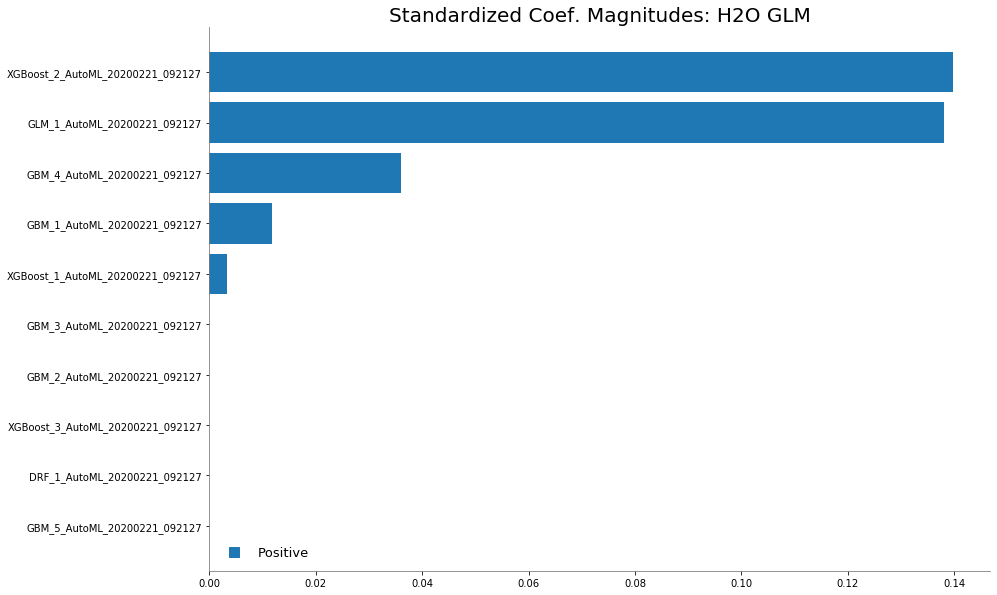

In [9]:
%matplotlib inline
metalearner.std_coef_plot()

In [12]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

In [13]:
metalearner.coef_norm()

{'Intercept': 0.00013135426244581638,
 'GBM_5_AutoML_20200221_201104': 0.0,
 'GBM_4_AutoML_20200221_201104': 0.0,
 'XGBoost_2_AutoML_20200221_201104': 0.0,
 'GBM_3_AutoML_20200221_201104': 0.0,
 'GBM_2_AutoML_20200221_201104': 0.0,
 'XGBoost_1_AutoML_20200221_201104': 0.0,
 'GLM_1_AutoML_20200221_201104': 0.0,
 'XGBoost_3_AutoML_20200221_201104': 0.0,
 'GBM_1_AutoML_20200221_201104': 0.0,
 'DRF_1_AutoML_20200221_201104': 0.0}

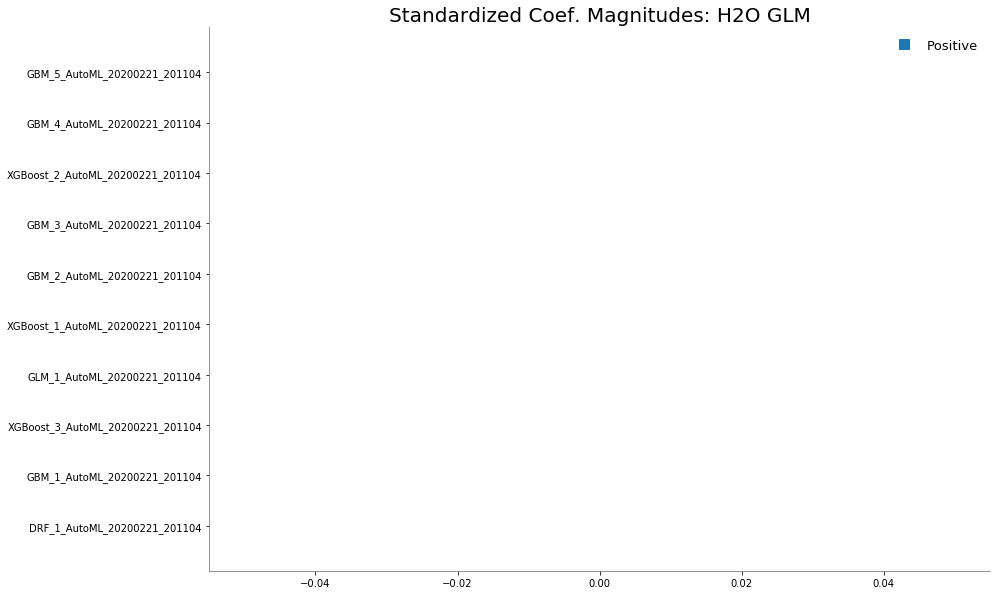

In [14]:
%matplotlib inline
metalearner.std_coef_plot()

In [8]:
h2o.save_model(aml.leader, path = "./saved_models/automl_002_bin")

'/home/alex/Documents/mlbase/disaster_tweet_kaggle/h2o/saved_models/automl_002_bin/StackedEnsemble_AllModels_AutoML_20200221_201104'

In [9]:
?h2o.save_model

Signature: h2o.save_model(model, path='', force=False)
Docstring:
Save an H2O Model object to disk. (Note that ensemble binary models can now be saved using this method.)

:param model: The model object to save.
:param path: a path to save the model at (hdfs, s3, local)
:param force: if True overwrite destination directory in case it exists, or throw exception if set to False.

:returns: the path of the saved model

:examples:
    
>>> from h2o.estimators.glm import H2OGeneralizedLinearEstimator
>>> h2o_df = h2o.import_file("http://s3.amazonaws.com/h2o-public-test-data/smalldata/prostate/prostate.csv.zip")
>>> my_model = H2OGeneralizedLinearEstimator(family = "binomial")
>>> my_model.train(y = "CAPSULE",
...                x = ["AGE", "RACE", "PSA", "GLEASON"],
...                training_frame = h2o_df)
>>> h2o.save_model(my_model, path='', force=True)
File:      ~/miniconda3/envs/h20/lib/python3.7/site-packages/h2o/h2o.py
Type:      function


In [10]:
X_test = sparse.load_npz("../processed_data/full_raw_keyword_bow_test_sparse.npz")
X_test = h2o.H2OFrame(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [19]:
predictions = aml.predict(X_test)

stackedensemble prediction progress: |██████ (failed)


OSError: Job with key $03017f00000132d4ffffffff$_8196bb3b970f73b7e68fec28eb254b20 failed with an exception: java.lang.NullPointerException
stacktrace: 
java.lang.NullPointerException
	at water.MRTask.dfork(MRTask.java:453)
	at water.MRTask.doAll(MRTask.java:390)
	at water.MRTask.doAll(MRTask.java:397)
	at hex.glm.GLMModel.predictScoreImpl(GLMModel.java:1734)
	at hex.Model.score(Model.java:1470)
	at hex.ensemble.StackedEnsembleModel.predictScoreImpl(StackedEnsembleModel.java:146)
	at hex.Model.score(Model.java:1470)
	at water.api.ModelMetricsHandler$1.compute2(ModelMetricsHandler.java:381)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1468)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


In [54]:
# Shut down and release RAM
h2o.cluster().shutdown()

H2O session _sid_a6a5 closed.
